# May ??, 2022 (badnpass, real space)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# RABIES
sys.path.insert(0, pjoin(git_dir, 'RABIES'))
from rabies.confound_correction_pkg.utils import butterworth as rb_butter

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice(192, full_load=True, load_allen=True, load_parcel=True)

In [6]:
from register.register import Register

reg = Register(mice)

In [7]:
obj_all = reg.register_anat(save_results=True, anchor_ses=2)

100%|██████████| 10/10 [02:21<00:00, 14.11s/it]


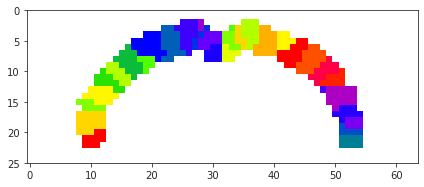

In [8]:
fig, ax = create_figure()
x = obj_all['sub-SLC02_ses-1']['cols'].numpy()
ax.imshow(mwh(x[..., 40].T == 0, x[..., 40].T), cmap='prism')
ax.set_ylim(25, 0)
plt.show()

In [10]:
file = 'sub-SLC10_ses-1_space-indiv2d_cortex.nii.gz'
file = pjoin(mice.cfg.masks_dir, file)
ctx = ants.image_read(file)

file = 'sub-SLC10_ses-1_space-indiv2d_cols.nii.gz'
file = pjoin(mice.cfg.masks_dir, file)
col = ants.image_read(file)

ctx = ctx.numpy().squeeze()
col = col.numpy().squeeze()

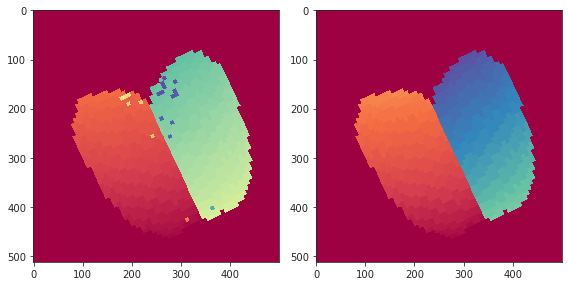

In [11]:
fig, axes = create_figure(1, 2, (8, 5))
axes[0].imshow(ctx, cmap='Spectral')
axes[1].imshow(col, cmap='Spectral')
plt.show()

## Take a look at HP vs non HP bold (RABIES)

In [2]:
mice = Mice(192, full_load=True, load_allen=True, load_parcel=True)

In [3]:
mice.band

{'bold': (0, 0.5), 'ca2': (0, 5.0)}

In [4]:
mice.set_band((0.01, 0.5), 0.5)
mice.band

{'bold': (0.01, 0.5), 'ca2': (0.5, 5.0)}

In [9]:
m = mice.mask3d['sub-SLC10_ses-2'].load_ants().numpy().astype(bool)

mice.setup_preproc_data(bold_hp=True)
f = mice.bold_preproc['sub-SLC10_ses-2_run-5']
print(f._patterns, f.nii_file)
x_hp = f.load_ants().numpy()

mice.setup_preproc_data(bold_hp=False)
f = mice.bold_preproc['sub-SLC10_ses-2_run-5']
print(f._patterns, f.nii_file)
x = f.load_ants().numpy()

['bold', 'desc-rabies-hp', 'run-5', 'ses-2', 'space-individual', 'sub-SLC10']
sub-SLC10_ses-2_task-rest_run-5_space-individual_desc-rabies-hp_bold.nii.gz

sub-SLC10_ses-2_task-rest_run-5_space-individual_desc-rabies_bold.nii.gz

In [11]:
tsnr = x.mean(-1) / x.std(-1)
tsnr_hp = x_hp.mean(-1) / x_hp.std(-1)

<matplotlib.image.AxesImage object at 0x7f8f849dcb50>

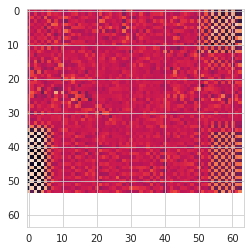

In [17]:
plt.imshow(tsnr[..., 25].T)

<matplotlib.image.AxesImage object at 0x7f8f849b4c40>

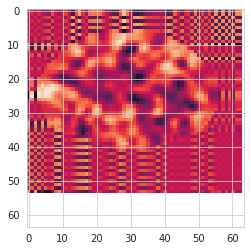

In [18]:
plt.imshow(tsnr_hp[..., 25].T)

<matplotlib.colorbar.Colorbar object at 0x7f8f823d62b0>

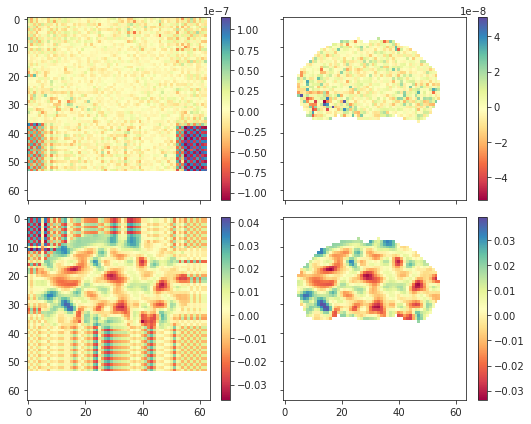

In [27]:
fig, axes = create_figure(2, 2, (7.5, 6), 'all', 'all')

im = axes[0, 0].imshow(tsnr[..., 30].T, cmap='Spectral')
plt.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(mwh(m[..., 30].T == 0, tsnr[..., 30].T), cmap='Spectral')
plt.colorbar(im, ax=axes[0, 1])

im = axes[1, 0].imshow(tsnr_hp[..., 30].T, cmap='Spectral')
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(mwh(m[..., 30].T == 0, tsnr_hp[..., 30].T), cmap='Spectral')
plt.colorbar(im, ax=axes[1, 1])

In [30]:
y, y_hp = x[m], x_hp[m]
y.shape, y_hp.shape

((54173, 550), (54173, 526))

[<matplotlib.lines.Line2D object at 0x7f8f7b343d30>]

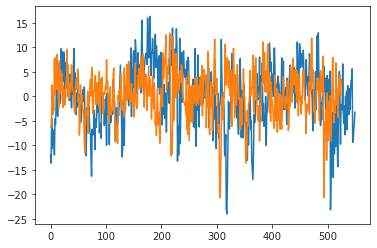

In [35]:
plt.plot(y.mean(0))
plt.plot(y_hp.mean(0))

In [66]:
f1, t1, sxx1 = sp_sig.spectrogram(y.mean(0), 1, nperseg=256)
f2, t2, sxx2 = sp_sig.spectrogram(y_hp.mean(0), 1, nperseg=256)
sxx1.shape, sxx2.shape

((129, 2), (129, 2))

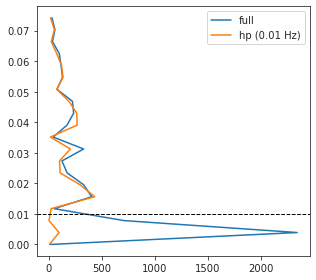

In [67]:
fig, ax = create_figure(1, 1, figsize=(4.5, 4))
ax.plot(sxx1.mean(1)[:20], f1[:20], label='full')
ax.plot(sxx2.mean(1)[:20], f2[:20], label='hp (0.01 Hz)')
ax.axhline(0.01, color='k', ls='--', lw=1)
ax.legend()
plt.show()

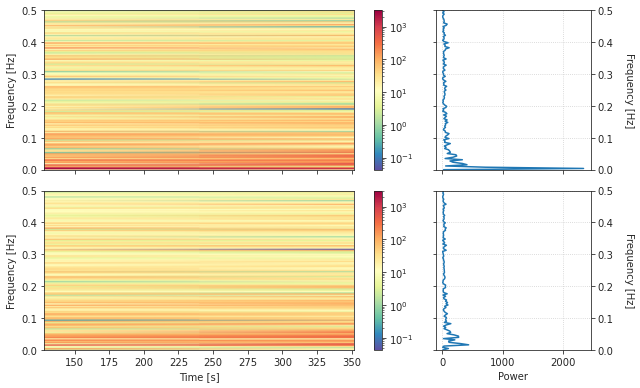

In [68]:
fig, axes = create_figure(2, 2, (9, 5.5), 'col', 'row', width_ratios=[1, 0.4])

kws = {
    'vmin': min(sxx1.min(), sxx2.min()),
    'vmax': max(sxx1.max(), sxx2.max()),
    'cmap': 'Spectral_r',
    'shading': 'gouraud',
    'norm': matplotlib.colors.LogNorm()
}

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=False,
        labelright=True,
    )
    if i == 1:
        axes[i, 0].set_xlabel('Time [s]')
        axes[i, 1].set_xlabel('Power')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()

In [88]:
nperseg = 256
f1, t1, sxx1 = sp_sig.spectrogram(y, 1, nperseg=nperseg)
f2, t2, sxx2 = sp_sig.spectrogram(y_hp, 1, nperseg=nperseg)
sxx1.shape, sxx2.shape

((54173, 129, 2), (54173, 129, 2))

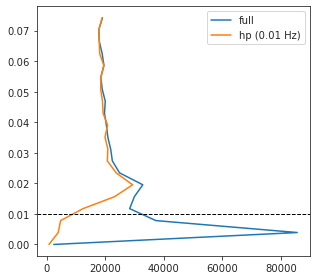

In [89]:
fig, ax = create_figure(1, 1, figsize=(4.5, 4))
ax.plot(sxx1.mean(0).mean(-1)[:20], f1[:20], label='full')
ax.plot(sxx2.mean(0).mean(-1)[:20], f2[:20], label='hp (0.01 Hz)')
ax.axhline(0.01, color='k', ls='--', lw=1)
ax.legend()
plt.show()

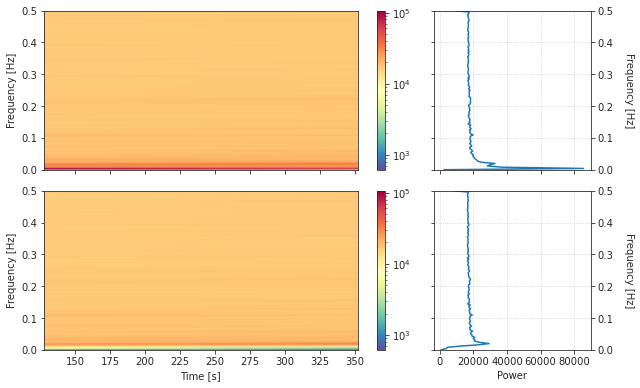

In [90]:
fig, axes = create_figure(2, 2, (9, 5.5), 'col', 'row', width_ratios=[1, 0.4])

kws = {
    'vmin': min(sxx1.mean(0).min(), sxx2.mean(0).min()),
    'vmax': max(sxx1.mean(0).max(), sxx2.mean(0).max()),
    'cmap': 'Spectral_r',
    'shading': 'gouraud',
    'norm': matplotlib.colors.LogNorm()
}

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1.mean(0)), (f2, t2, sxx2.mean(0))]):
    im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=False,
        labelright=True,
    )
    if i == 1:
        axes[i, 0].set_xlabel('Time [s]')
        axes[i, 1].set_xlabel('Power')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()

## Implement CA prepare function

Includes:
- filter_ab: take out the first 50 seconds of CA2 data
- filter_std: find out large outlier timepoints and remove them (use: nb_std = 5)
- goal is to find what is good_t:
    - First of all, it is the range (1000, 6000)
    - Second of all, the bad t is largely the ones put out by RABIES
    - Supplement the RABIES time mask by nb_std time masks
- After finding good_t, then simulate the bad_t using RABIES implementation
- Once bad_t is filled using simulated time points, perform bandpassing (or high passing)
- After bandpassing, bad_t is augmented with 150 timepoints from each side (Power thing)
- Finally, remove all bad_t and you are done.

In [114]:
_k = 'sub-SLC10_ses-2'
key = 'sub-SLC10_ses-2_run-5'
m = mice.mask3d[_k].load_ants().numpy().astype(bool)
func = mice.ca_preproc[key]
vars(func)

{
    'cfg': <model.configuration.Config object at 0x7f90ec35d370>,
    '_patterns': [
        'ca2',
        'desc-preproc',
        'run-5',
        'ses-2',
        'space-individual',
        'sub-SLC10'
    ],
    'key': 'sub-SLC10_ses-2_run-5',
    'mode': 'ca2',
    'space': 'individual',
    'npy_dir': None,
    'nii_file': 'sub-SLC10_ses-2_task-rest_run-5_space-individual_desc-preproc_ca2.nii.gz',
    'npy_file': None,
    'dtype': <class 'float'>,
    '_npy': None,
    'shape': None,
    'task': 'rest'
}

In [115]:
x = func.load_ants().numpy().astype(float)
x.shape

(256, 250, 1, 6000)

In [116]:
band = (0.5, 5.0)

file_name = '_'.join([
    key,
    f"task-{func.task}",
    f"space-CCF2d",
    f"desc-bp{band}".replace(' ', ''),
    func.mode,
])
file_name

'sub-SLC10_ses-2_run-5_task-rest_space-CCF2d_desc-bp(0.5,5.0)_ca2'

In [117]:
from register.register import Register

reg = Register(mice)
tsnr_masks = reg.get_tsnr_masks(q_bold=0.1)

Name: cortex . . . a total of: 224 regions accepted, 160 regions rejected.
accept ratio: 58.33 %, reject ratio: 41.67 %, using a presence threshold of 20.0 %

In [130]:
m_indiv = mice.mask2d[_k].load_ants()
m_indiv = m_indiv.numpy().astype(bool)
m_tsnr = tsnr_masks['ca2'].get(key)

<matplotlib.image.AxesImage object at 0x7f8f7377dbb0>

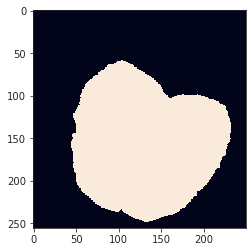

In [131]:
plt.imshow(m_indiv)

In [132]:
m_indiv.sum()

25104

<matplotlib.image.AxesImage object at 0x7f8f7a5f64f0>

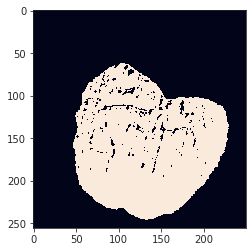

In [133]:
plt.imshow(m_tsnr)

In [134]:
if m_tsnr is not None:
    msg = f"Organizing {key} ({'ca2'})  .  .  .  "
    msg += f"tSNR mask # deleted pix/vox:  "
    msg += str(np.logical_and(m_indiv, ~m_tsnr).sum())
    m_indiv = np.logical_and(m_indiv, m_tsnr)
print(msg)

Organizing sub-SLC10_ses-2_run-5 (ca2)  .  .  .  tSNR mask # deleted pix/vox:  2648

<matplotlib.image.AxesImage object at 0x7f8f73cbd190>

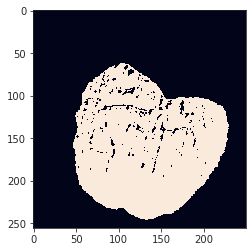

In [135]:
plt.imshow(m_indiv)

In [138]:
2648 / 25104 * 100

10.548119821542384

In [143]:
2648 / (m_indiv.sum() + 2648)

0.10548119821542384

In [141]:
y = x[m_indiv]
y.shape

(22456, 1, 6000)

In [144]:
y[..., 500:].shape

(22456, 1, 5500)

[<matplotlib.lines.Line2D object at 0x7f8f6e238220>]

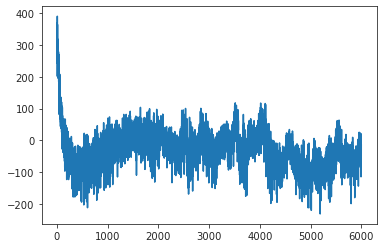

In [145]:
plt.plot(y.mean(0).squeeze())

In [10]:
net = Network(mice=mice, key=mice.get_key(10, 3, 1), mode='ca2', task='rest', band=0.5)
net.base_name

'n-192*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC10_ses-3_run-1'

In [11]:
net = Network(mice=mice, key=mice.get_key(10, 3, 1), mode='ca2', task='rest', band=(0.01, 0.5))
net.base_name

'n-192*3_bp(0.01,0.5)_ca2_rest_pearson_sub-SLC10_ses-3_run-1'

In [12]:
net = Network(mice=mice, key=mice.get_key(10, 3, 1), mode='bold-lite', task='rest', band=0.01)
net.base_name

'n-192*3_bp(0.01,0.5)_bold-lite_rest_pearson_sub-SLC10_ses-3_run-1'

In [23]:
graph_type = 'real'
num_k = 7
perc = 'p20-sample'
band = None# (0.01, 0.5)
match_metric = 'euclidean'

fit_name = [
    graph_type,
    f"k{num_k}",
    perc,
    f"bp{band}".replace(' ', '')
    if band else band,
    match_metric,
    'linksampling',
]
fit_name = [e for e in fit_name if e]
fit_name = '-'.join([*fit_name, now()])

In [24]:
fit_name

'real-k7-p20-sample-euclidean-linksampling-(2022_05_11)'

In [91]:
x = np.random.randn(600, 50)
y = rb_butter(x, 1, high_pass=0.1, low_pass=None)
y.shape

(600, 50)

[<matplotlib.lines.Line2D object at 0x7f94d1ecfbe0>]

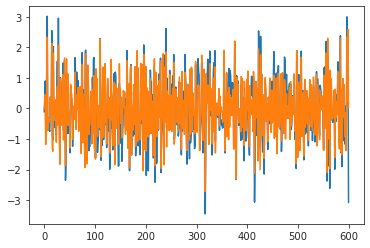

In [92]:
plt.plot(x[:, 0])
plt.plot(y[:, 0])

In [93]:
f1, t1, sxx1 = sp_sig.spectrogram(x[:, 0], 1, nperseg=128)
f2, t2, sxx2 = sp_sig.spectrogram(y[:, 0], 1, nperseg=128)

f2.shape, t2.shape, sxx2.shape

((65,), (5,), (65, 5))

In [94]:
t2

array([ 64., 176., 288., 400., 512.])

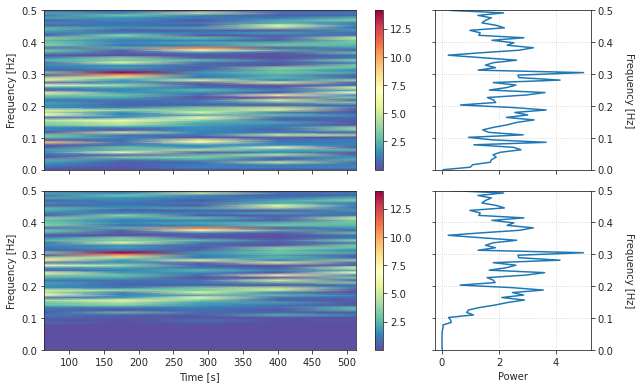

In [95]:
fig, axes = create_figure(2, 2, (9, 5.5), 'col', 'row', width_ratios=[1, 0.4])

kws = {
    'vmin': min(sxx1.min(), sxx2.min()),
    'vmax': max(sxx1.max(), sxx2.max()),
    'cmap': 'Spectral_r',
    'shading': 'gouraud',
}

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=False,
        labelright=True,
    )
    if i == 1:
        axes[i, 0].set_xlabel('Time [s]')
        axes[i, 1].set_xlabel('Power')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()

## 128 * 3

In [134]:
mice = Mice(Config(128, 3, exclude=0))
mice.setup_func_data('rest', runs_only=True)

### Anim = 10

In [135]:
key = mice.get_key(10, 3, 1)
base = Base(mice, key=key, mode='ca2', prep_data=True)

In [136]:
base.data.shape

(154, 6000)

[<matplotlib.lines.Line2D object at 0x7f94cbad40a0>]

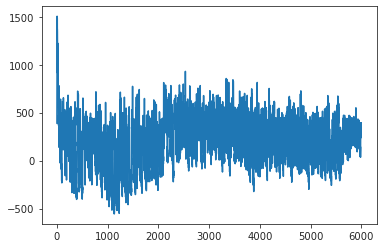

In [137]:
plt.plot(base.data[70])

In [138]:
f1, t1, sxx1 = sp_sig.spectrogram(base.data[70], 10, nperseg=512)
f2, t2, sxx2 = sp_sig.spectrogram(base.data[70][1000:], 10, nperseg=512)

f2.shape, t2.shape, sxx2.shape

((257,), (11,), (257, 11))

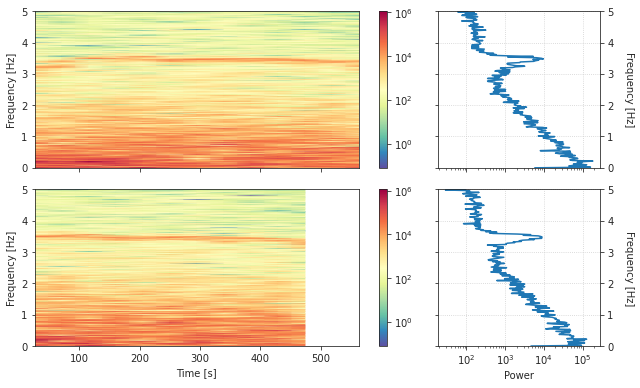

In [139]:
fig, axes = create_figure(2, 2, (9, 5.5), 'col', 'row', width_ratios=[1, 0.4])

kws = {
    'vmin': min(sxx1.min(), sxx2.min()),
    'vmax': max(sxx1.max(), sxx2.max()),
    'cmap': 'Spectral_r',
    'shading': 'gouraud',
    'norm': matplotlib.colors.LogNorm()
}

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=False,
        labelright=True,
    )
    if i == 1:
        axes[i, 0].set_xlabel('Time [s]')
        axes[i, 1].set_xlabel('Power')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()
    axes[i, 1].set_xscale('log')

plt.show()

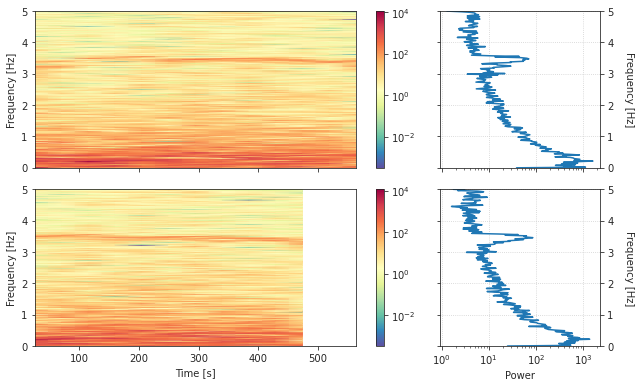

In [140]:
f1, t1, sxx1 = sp_sig.spectrogram(base.data[90], 10, nperseg=512)
f2, t2, sxx2 = sp_sig.spectrogram(base.data[90][1000:], 10, nperseg=512)

fig, axes = create_figure(2, 2, (9, 5.5), 'col', 'row', width_ratios=[1, 0.4])

kws = {
    'vmin': min(sxx1.min(), sxx2.min()),
    'vmax': max(sxx1.max(), sxx2.max()),
    'cmap': 'Spectral_r',
    'shading': 'gouraud',
    'norm': matplotlib.colors.LogNorm()
}

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=False,
        labelright=True,
    )
    if i == 1:
        axes[i, 0].set_xlabel('Time [s]')
        axes[i, 1].set_xlabel('Power')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()
    axes[i, 1].set_xscale('log')

plt.show()

### Anim = 5

In [141]:
key = mice.get_key(5, 3, 1)
base = Base(mice, key=key, mode='ca2', prep_data=True)

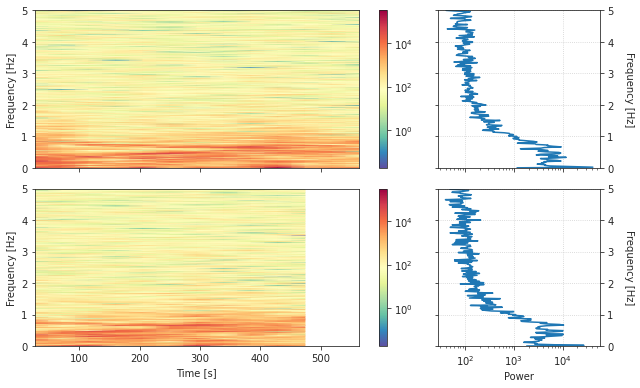

In [152]:
f1, t1, sxx1 = sp_sig.spectrogram(base.data[70], 10, nperseg=512)
f2, t2, sxx2 = sp_sig.spectrogram(base.data[70][1000:], 10, nperseg=512)

fig, axes = create_figure(2, 2, (9, 5.5), 'col', 'row', width_ratios=[1, 0.4])

kws = {
    'vmin': min(sxx1.min(), sxx2.min()),
    'vmax': max(sxx1.max(), sxx2.max()),
    'cmap': 'Spectral_r',
    'shading': 'gouraud',
    'norm': matplotlib.colors.LogNorm()
}

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=False,
        labelright=True,
    )
    if i == 1:
        axes[i, 0].set_xlabel('Time [s]')
        axes[i, 1].set_xlabel('Power')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()
    axes[i, 1].set_xscale('log')

plt.show()

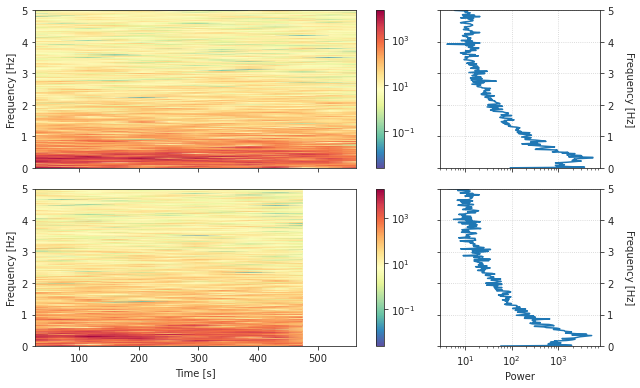

In [157]:
f1, t1, sxx1 = sp_sig.spectrogram(base.data[90], 10, nperseg=512)
f2, t2, sxx2 = sp_sig.spectrogram(base.data[90][1000:], 10, nperseg=512)

fig, axes = create_figure(2, 2, (9, 5.5), 'col', 'row', width_ratios=[1, 0.4])

kws = {
    'vmin': min(sxx1.min(), sxx2.min()),
    'vmax': max(sxx1.max(), sxx2.max()),
    'cmap': 'Spectral_r',
    'shading': 'gouraud',
    'norm': matplotlib.colors.LogNorm()
}

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=False,
        labelright=True,
    )
    if i == 1:
        axes[i, 0].set_xlabel('Time [s]')
        axes[i, 1].set_xlabel('Power')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()
    axes[i, 1].set_xscale('log')

plt.show()